## Fashion MNIST classification

In [1]:
import os, sys, imp

import keras

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import datasets as D
imp.reload(D)

import utils as U
imp.reload(U)

import plot_lib as pl
imp.reload(pl)

import numpy as np
import datetime

from timeit import default_timer as timer

pl.set_default()

/var/folders/b9/jjp98g8j2mbcn65j0fgl0dzw0000gp/T/ipykernel_66033/1785701380.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import os, sys, imp


In [2]:
# Constants
MODELDIR = "models"
BATCH_SIZE = 32
EPOCHS = 20

### Load and preprocess images

In [3]:
(X_train, y_train), (X_test, y_test) = D.load_fashion_mnist_data()
X_train = X_train.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

In [4]:
[n_train, d1, d2] = X_train.shape
n_test = X_test.shape[0]

nc = len(np.unique(y_train)) # number of classes
print(f"num classes: {nc}")

num classes: 10


### Visualize images

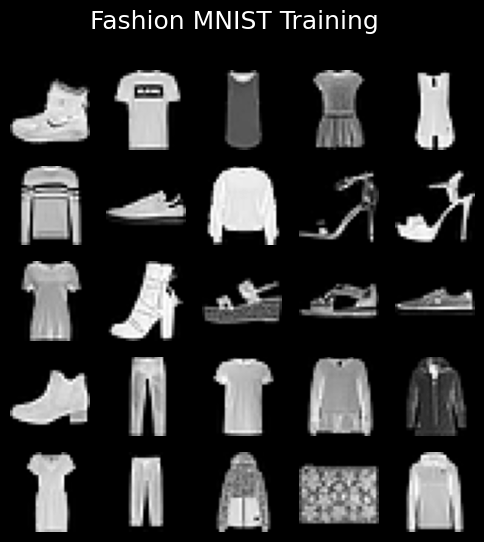

In [5]:
# Visualize training samples
U.visualize_dataset(X_train, title="Fashion MNIST Training", n_samples=25)

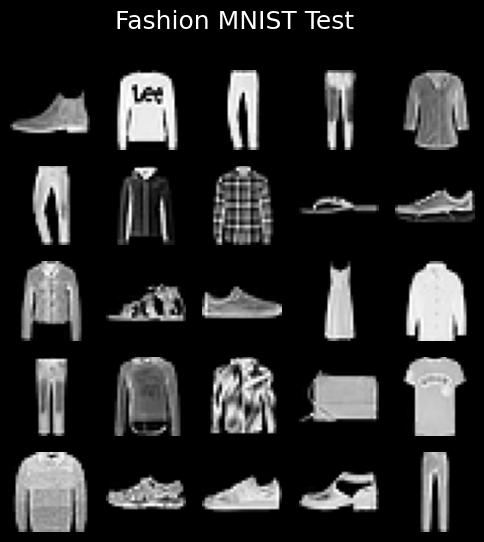

In [14]:
# Visualize test samples
U.visualize_dataset(X_test, title="Fashion MNIST Test", n_samples=25)

### Train ConvNet

Model: "fashion_convnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 48)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1200)          

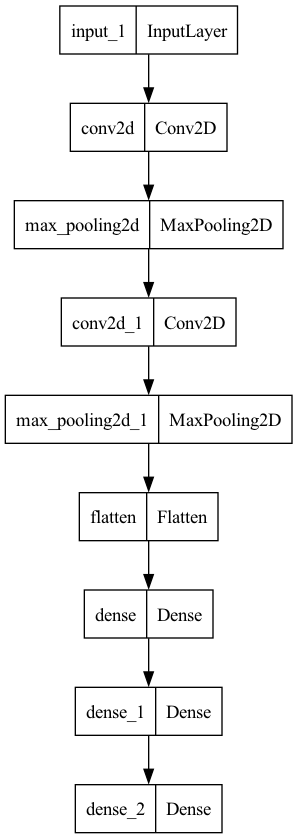

In [6]:
input_shape = (d1, d2, 1)
inputs = keras.Input(shape=input_shape)
x = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", activation="relu")(inputs)

x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(48, kernel_size=(5, 5), padding="valid", activation="relu")(x)

x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = keras.layers.Flatten()(x)


x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(nc)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="fashion_convnet")
model.summary()

keras.utils.plot_model(model)

In [7]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.legacy.Adam(learning_rate=1e-4)
accuracy = keras.metrics.SparseCategoricalAccuracy()

In [8]:
# Define callbacks: Tensorboard, Model Checkpoint, Timing
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir="./logs/convnet-fashion/" + current_time,
    update_freq="epoch"
)

checkpoint_dir = os.path.join(MODELDIR, f"convnet-fashion-{current_time}")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_filepath = os.path.join(checkpoint_dir, "weights-{epoch:02d}-{val_loss:.2f}.hdf5")
modelcp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True
)

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

timing_callback = TimingCallback()

In [9]:
# Compile model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[accuracy],
)

In [10]:
# Train model
history = model.fit(
    x=X_train,
    y=y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[tensorboard_callback, modelcp_callback, timing_callback]
)

Epoch 1/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.6501 - sparse_categorical_accuracy: 0.7653 - val_loss: 0.4717 - val_sparse_categorical_accuracy: 0.8319
Epoch 2/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.4208 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.4050 - val_sparse_categorical_accuracy: 0.8571
Epoch 3/20
1875/1875 [==============================] - 16s 9ms/step - loss: 0.3593 - sparse_categorical_accuracy: 0.8716 - val_loss: 0.3764 - val_sparse_categorical_accuracy: 0.8658
Epoch 4/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.3239 - sparse_categorical_accuracy: 0.8834 - val_loss: 0.3441 - val_sparse_categorical_accuracy: 0.8775
Epoch 5/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2998 - sparse_categorical_accuracy: 0.8922 - val_loss: 0.3142 - val_sparse_categorical_accuracy: 0.8873
Epoch 6/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2782 -

In [21]:
# print(timing_callback.logs)
print(f"Elapsed time: {sum(timing_callback.logs):.4f} seconds")

Elapsed time: 321.0565 seconds


In [22]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [23]:
history.history["val_sparse_categorical_accuracy"]

[0.8284000158309937,
 0.8564000129699707,
 0.8726999759674072,
 0.8845000267028809,
 0.8871999979019165,
 0.8895999789237976,
 0.8907999992370605,
 0.8946999907493591,
 0.9034000039100647,
 0.8985999822616577,
 0.9075999855995178,
 0.9072999954223633,
 0.9070000052452087,
 0.909500002861023,
 0.9082000255584717,
 0.911300003528595,
 0.9115999937057495,
 0.9085000157356262,
 0.9121000170707703,
 0.9122999906539917]

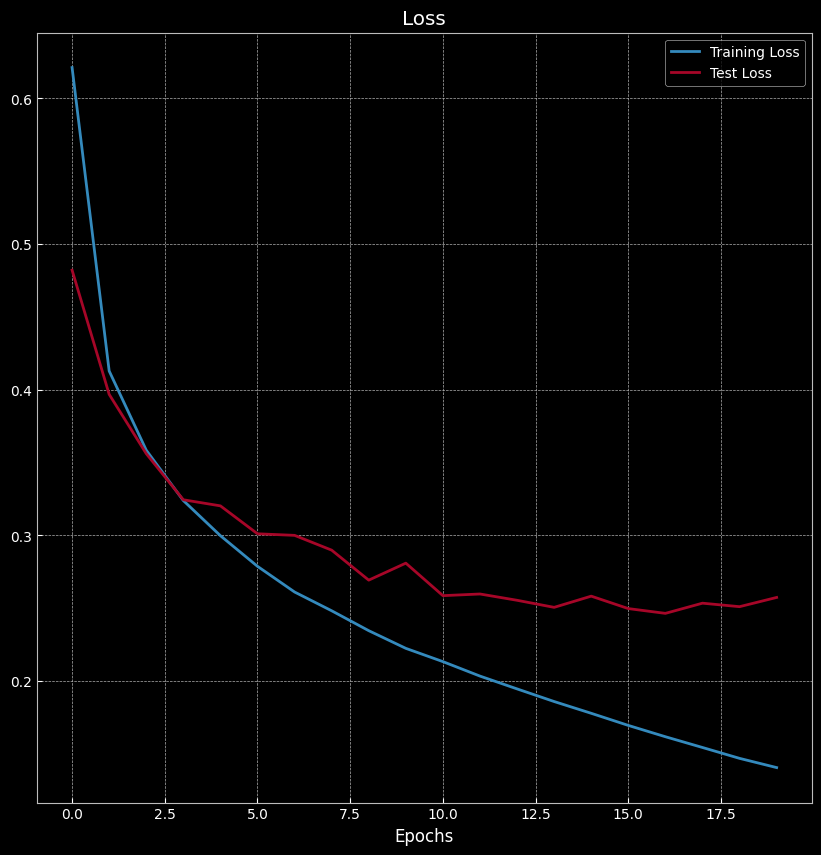

In [24]:
train_loss = history.history["loss"]
test_loss = history.history["val_loss"]
pl.plot_results(
    train_loss,
    test_loss,
    xlabel="Epochs",
    legend=["Training Loss", "Test Loss"],
    title="Loss"
)

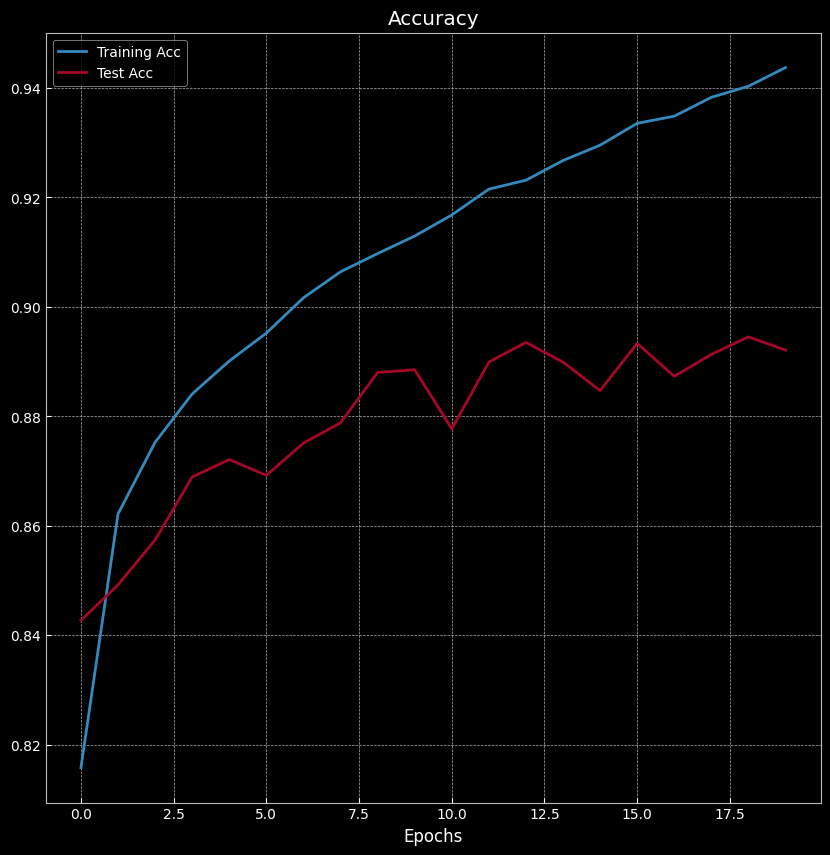

In [16]:
train_acc = history.history["sparse_categorical_accuracy"]
test_acc = history.history["val_sparse_categorical_accuracy"]

pl.plot_results(
    train_acc,
    test_acc,
    xlabel="Epochs",
    legend=["Training Acc", "Test Acc"],
    title="Accuracy"
)